In [1]:
library(tidyverse)
library(ggpubr)
library(yaml)
library(patchwork)

#read config
config <- read_yaml(file = "../CHARM/config.yaml")

#Common
Raw <- read_table2("../stat/raw.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3],X1 = strsplit(X1,split = "_")[[1]][1])
DNA <- read_table2("../stat/dna.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise()%>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3])
RNA <- read_table2("../stat/rna.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3])

raw_pairs <- read_table2("../stat/raw.pairs.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])
pairs_dedup <- read_table2("../stat/pairs.dedup.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])

pairs_c1 <- read_table2("../stat/pairs.c1.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
pairs_c12 <- read_table2("../stat/pairs.c12.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
pairs_c123 <- read_table2("../stat/pairs.c123.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
inter_pairs_c123 <- read_table2(file = "../stat/inter.pairs.c123.stat",col_names = F) %>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))

yperx <- read_table2("../stat/yperx.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][2])
stat <- Raw %>% left_join(DNA,by="X1") %>% left_join(RNA,by="X1") %>% left_join(yperx,by="X1") %>% left_join(raw_pairs,by="X1") %>% left_join(pairs_dedup,by="X1") %>% 
    left_join(pairs_c1,by="X1") %>% left_join(pairs_c12,by="X1")%>% left_join(pairs_c123,by="X1") %>% left_join(inter_pairs_c123,by="X1")
RNAres <- read_table2("../result/RNA_Res/counts.gene.total.format.tsv")
featureStat <- cbind(as.data.frame(colSums(RNAres %>% select(-gene))),colSums(RNAres %>% select(-gene) != 0)) %>% rownames_to_column("X1")
RNAresExon <- read_table2("../result/RNA_Res/counts.exon.total.format.tsv")
featureStatExon <- cbind(as.data.frame(colSums(RNAresExon %>% select(-gene))),colSums(RNAresExon %>% select(-gene) != 0))  %>% rownames_to_column("X1")

if(config$if_RNA_snp_split){
    RNAresGenome1 <- read_table2("../result/RNA_Res/counts.gene.genome1.tsv")
    RNAresGenome2 <- read_table2("../result/RNA_Res/counts.gene.genome2.tsv")
    featureStatGenome1 <- cbind(as.data.frame(colSums(RNAresGenome1 %>% select(-gene))),colSums(RNAresGenome1 %>% select(-gene) != 0)) %>% rownames_to_column("X1")
    featureStatGenome2 <- cbind(as.data.frame(colSums(RNAresGenome2 %>% select(-gene))),colSums(RNAresGenome2 %>% select(-gene) != 0)) %>% rownames_to_column("X1")
    stat <- stat %>% left_join(featureStat,by="X1") %>% left_join(featureStatExon,by="X1") %>% left_join(featureStatGenome1,by="X1")  %>% left_join(featureStatGenome2,by="X1")
    names(stat) <- c("cellname","Rawreads","DNAreads","RNAreads","yperx","raw_pairs","pairs_dedup","pairs_clean1","pairs_clean2","pairs_clean3","inter_pairs_clean3",
                     "UMIs_gene","genes_gene","UMIs_exon","genes_exon","UMIs_gene_genome1","genes_gene_genome1","UMIs_gene_genome2","genes_gene_genome2")
} else{
    stat <- stat %>% left_join(featureStat,by="X1") %>% left_join(featureStatExon,by="X1") 
    names(stat) <- c("cellname","Rawreads","DNAreads","RNAreads","yperx","raw_pairs","pairs_dedup","pairs_clean1","pairs_clean2","pairs_clean3","inter_pairs_clean3",
                     "UMIs_gene","genes_gene","UMIs_exon","genes_exon")
}

if(config$if_structure){
    rmsd <- read_table2("../stat/rmsd.info",col_names = F) %>% rowwise() %>% mutate(X1=str_split(X1,pattern = fixed("/")),cellname = X1[1], res = str_split(X1[3], fixed("."))[[1]][2],TOP3_RMSD = X5) %>% select(cellname,res,TOP3_RMSD) %>% spread(res,TOP3_RMSD) %>% arrange(cellname)
    stat <- stat %>% left_join(rmsd)
}

if (config$if_charm){
    reads <- tibble("cellname"=NA)
    for(i in 1:length(names(config$split))){
        temp <- read_csv(paste0("../stat/",names(config$split)[i],".read.stat"),col_names = F) %>% rowwise() %>% mutate(X2 = X2*300/1000000000)
        names(temp) <- c("cellname",paste0(names(config$split)[i],"_reads"))
        reads <- reads %>% full_join(temp)
    }
    reads <- reads %>% filter(!is.na(cellname))
    stat <- stat %>% full_join(reads)
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
ℹ Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_char

In [2]:
plot <- stat %>% mutate(RNAreadsRatio = RNAreads/(RNAreads+DNAreads),
                        pairsPerRead = raw_pairs/DNAreads/1000000000*300,
                        pairsValidRatio = pairs_clean3/raw_pairs,
                        interPairsRatio = inter_pairs_clean3/pairs_clean3) 
plot[is.na(plot)]<-0

In [3]:
options(repr.matrix.max.cols=100, repr.matrix.max.rows=20)
plot

cellname,Rawreads,DNAreads,RNAreads,yperx,raw_pairs,pairs_dedup,pairs_clean1,pairs_clean2,pairs_clean3,inter_pairs_clean3,UMIs_gene,genes_gene,UMIs_exon,genes_exon,ct_reads,atac_reads,RNAreadsRatio,pairsPerRead,pairsValidRatio,interPairsRatio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mESCP2ENH3K27me3EN001,2.584428,2.547299,0.0328518,0.004400,3289401,500025,493231,407898,407723,71993,15738,5235,3636,2158,1.2864753,1.1014176,0.012732514,0.3873988,0.12395053,0.17657331
mESCP2ENH3K27me3EN002,1.094818,1.080802,0.0124392,0.005562,1360787,264104,260429,192420,192368,54546,11174,4229,2584,1676,0.6438711,0.3999042,0.011378280,0.3777160,0.14136525,0.28355028
mESCP2ENH3K27me3EN003,1.467588,1.442522,0.0223755,0.005869,1730438,307862,304240,237009,236905,44544,12064,4621,2752,1798,0.8934540,0.4391565,0.015274453,0.3598778,0.13690464,0.18802474
mESCP2ENH3K27me3EN004,2.736115,2.696424,0.0352986,0.004290,3146391,415786,408513,312801,312680,60307,12222,4821,2718,1721,1.5760191,0.8866572,0.012921735,0.3500626,0.09937735,0.19287131
mESCP2ENH3K27me3EN005,1.445962,1.430708,0.0133299,0.005877,1985449,366696,361670,273840,273695,61907,10476,4278,2296,1527,0.8676156,0.5453403,0.009230988,0.4163215,0.13785043,0.22618974
mESCP2ENH3K27me3EN006,1.195360,1.175877,0.0171804,0.007629,1351387,276382,272927,196906,196807,37284,7725,3559,1765,1287,0.5190093,0.4763355,0.014400309,0.3447776,0.14563334,0.18944448
mESCP2ENH3K27me3EN007,1.197206,1.188721,0.0070632,0.006972,1483615,290541,287362,222484,222400,19351,2365,1744,553,443,0.6363333,0.3850893,0.005906750,0.3744230,0.14990412,0.08700989
mESCP2ENH3K27me3EN008,3.265293,3.231443,0.0301482,0.006443,4195357,501806,492878,401402,401239,87238,18713,5601,4142,2396,2.1313410,1.1038716,0.009243401,0.3894876,0.09563882,0.21742154
mESCP2ENH3K27me3EN009,2.205776,2.170873,0.0311373,0.010723,2684727,436387,427922,336142,336009,67409,18704,5668,4371,2455,1.3801338,0.7008363,0.014140400,0.3710112,0.12515574,0.20061665


# Run below if this is a CHARM experiment

In [4]:
cellnames=plot$cellname

In [5]:
library(Signac) %>% suppressMessages()
library(Seurat) %>% suppressMessages()
library(EnsDb.Mmusculus.v79)%>% suppressMessages()
library(BSgenome.Mmusculus.UCSC.mm10)%>% suppressMessages()
library(future)%>% suppressMessages()

plan("multicore",workers=10)

atac_fragments = CreateFragmentObject("../result/fragments/atac.fragments.bgz",cells = cellnames)
ct_fragments = CreateFragmentObject("../result/fragments/ct.fragments.bgz",cells = cellnames)
mm10gnme <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
atac_count_matrix = GenomeBinMatrix(atac_fragments,binsize = 5000,genome = mm10gnme)
ct_count_matrix = GenomeBinMatrix(ct_fragments,binsize = 5000,genome = mm10gnme)

atac_assay <- CreateChromatinAssay(counts = atac_count_matrix, fragments = atac_fragments, genome = "mm10")
ct_assay <- CreateChromatinAssay(counts = ct_count_matrix, fragments = ct_fragments, genome = "mm10")


Computing hash

Computing hash

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [6]:
charm = RNAres %>% column_to_rownames("gene") %>% as.matrix() %>% CreateSeuratObject(assay="rna")
charm[["atac"]] <- atac_assay
charm[["ct"]] <- ct_assay

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [7]:
DefaultAssay(charm) <- "atac"
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"
Annotation(charm) <- annotations
Annotation(charm[["ct"]]) <- annotations

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [25]:
options(future.globals.maxSize = 1024 * 1024 * 1024 * 8)
charm <- TSSEnrichment(charm, fast = FALSE,region_extension =2000,assay="atac")
charm@meta.data %>% dplyr::rename(TSS.enrichment.atac = TSS.enrichment,TSS.percentile.atac = TSS.percentile) -> charm@meta.data
charm <- TSSEnrichment(charm, fast = FALSE,region_extension =2000,assay="ct")
charm@meta.data %>% dplyr::rename(TSS.enrichment.ct = TSS.enrichment,TSS.percentile.ct = TSS.percentile) -> charm@meta.data

Extracting TSS positions



Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



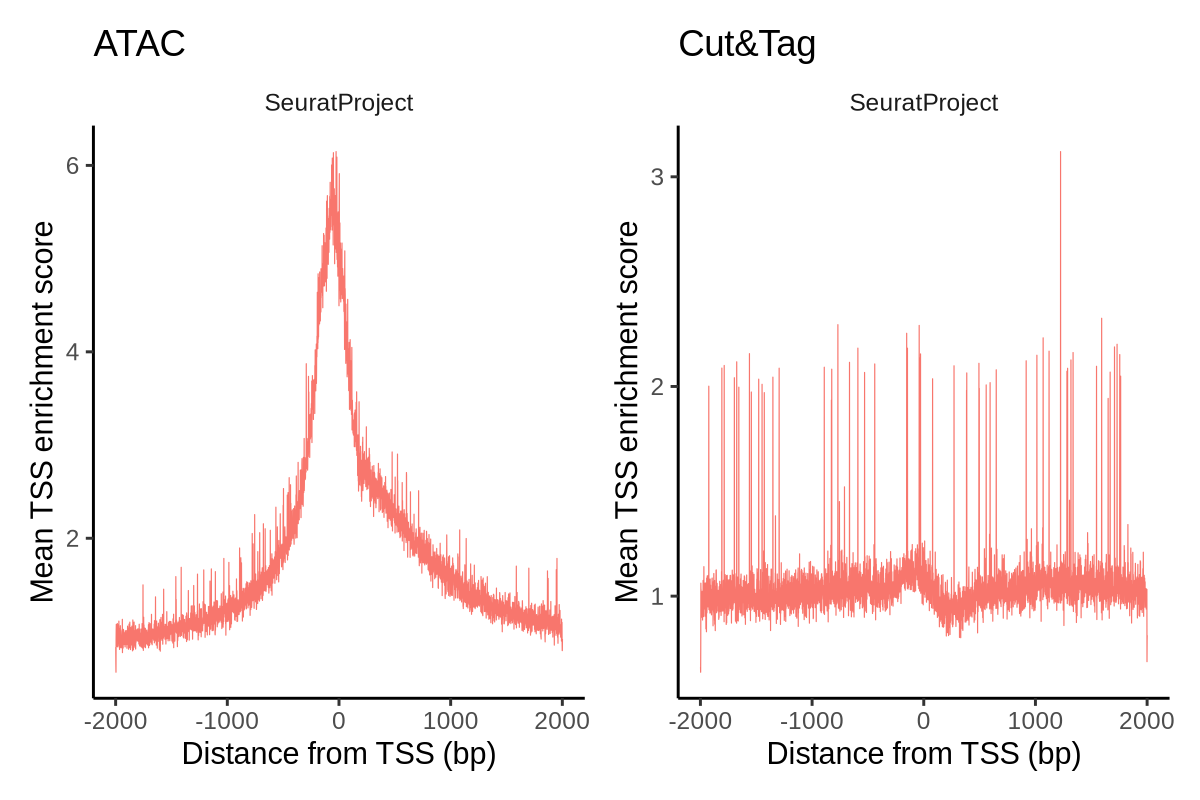

In [34]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res = 200)
TSSPlot(charm,assay="atac") + NoLegend() + ggtitle("ATAC")| TSSPlot(charm,assay="ct") + NoLegend() + ggtitle("Cut&Tag")

In [39]:
charm[[]] %>% rownames_to_column("cellname") %>% mutate(temp=cellname) %>% column_to_rownames("temp") -> charm@meta.data

In [51]:
plot %>%  full_join(
                        charm@meta.data %>% dplyr::select(cellname,nCount_atac,nCount_ct,TSS.enrichment.atac,TSS.enrichment.ct),
                    by="cellname") -> plot

In [53]:
plot

cellname,Rawreads,DNAreads,RNAreads,yperx,raw_pairs,pairs_dedup,pairs_clean1,pairs_clean2,pairs_clean3,inter_pairs_clean3,UMIs_gene,genes_gene,UMIs_exon,genes_exon,ct_reads,atac_reads,RNAreadsRatio,pairsPerRead,pairsValidRatio,interPairsRatio,nCount_atac,nCount_ct,TSS.enrichment.atac,TSS.enrichment.ct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mESCP2ENH3K27me3EN001,2.584428,2.547299,0.0328518,0.004400,3289401,500025,493231,407898,407723,71993,15738,5235,3636,2158,1.2864753,1.1014176,0.012732514,0.3873988,0.12395053,0.17657331,66438,84756,3.434875,1.1214011
mESCP2ENH3K27me3EN002,1.094818,1.080802,0.0124392,0.005562,1360787,264104,260429,192420,192368,54546,11174,4229,2584,1676,0.6438711,0.3999042,0.011378280,0.3777160,0.14136525,0.28355028,51767,89437,2.507236,1.0445251
mESCP2ENH3K27me3EN003,1.467588,1.442522,0.0223755,0.005869,1730438,307862,304240,237009,236905,44544,12064,4621,2752,1798,0.8934540,0.4391565,0.015274453,0.3598778,0.13690464,0.18802474,47100,97599,3.704353,1.0531997
mESCP2ENH3K27me3EN004,2.736115,2.696424,0.0352986,0.004290,3146391,415786,408513,312801,312680,60307,12222,4821,2718,1721,1.5760191,0.8866572,0.012921735,0.3500626,0.09937735,0.19287131,54175,92052,3.034988,1.0030693
mESCP2ENH3K27me3EN005,1.445962,1.430708,0.0133299,0.005877,1985449,366696,361670,273840,273695,61907,10476,4278,2296,1527,0.8676156,0.5453403,0.009230988,0.4163215,0.13785043,0.22618974,65790,116128,3.866299,1.1433917
mESCP2ENH3K27me3EN006,1.195360,1.175877,0.0171804,0.007629,1351387,276382,272927,196906,196807,37284,7725,3559,1765,1287,0.5190093,0.4763355,0.014400309,0.3447776,0.14563334,0.18944448,42416,51190,3.346437,1.0120148
mESCP2ENH3K27me3EN007,1.197206,1.188721,0.0070632,0.006972,1483615,290541,287362,222484,222400,19351,2365,1744,553,443,0.6363333,0.3850893,0.005906750,0.3744230,0.14990412,0.08700989,26684,45661,2.978942,0.9115383
mESCP2ENH3K27me3EN008,3.265293,3.231443,0.0301482,0.006443,4195357,501806,492878,401402,401239,87238,18713,5601,4142,2396,2.1313410,1.1038716,0.009243401,0.3894876,0.09563882,0.21742154,73568,153209,3.622970,1.1408796
mESCP2ENH3K27me3EN009,2.205776,2.170873,0.0311373,0.010723,2684727,436387,427922,336142,336009,67409,18704,5668,4371,2455,1.3801338,0.7008363,0.014140400,0.3710112,0.12515574,0.20061665,68590,139684,3.170461,1.0408053


In [54]:
plot %>% write_tsv("../metadata_raw.tsv")

In [56]:
charm %>% saveRDS("../result/charm.rds")